# eth, hotel, univ, zara1, and zara2

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Reshape, Input
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


| Model                | eth        | zara1      | zara2      | hotel      | univ       |
|----------------------|------------|------------|------------|------------|------------|
| **Seq2seq_vanilla**  | 0.72/1.43   | 0.47/0.93   | 0.40/0.79   | 2.54/3.72   | 0.82/1.59   |
| **Seq2seq_Bidirectional** | 0.77/1.67   | 0.60/1.09   | 0.39/0.82   | 2.51/3.98   | 0.89/1.68   |
| **Seq2seq_attention**    | 0.76/1.56   | 0.58/1.09   | 0.57/1.05   | 1.27/2.26   | 0.95/1.69   |
| **Seq2seq_Cov1D**        | 0.95/1.69   | 0.59/1.07   | 0.42/0.76   | 4.68/5.82   | 0.89/1.63   |
| **Seq2seq_tcn_attention**| 1.01/1.61   | 0.55/1.00   | 0.63/0.96   | 3.68/4.25   | 1.12/1.88   |


# Utility Function


In [11]:
# Custom loss functions
def calculate_ADE(y_true, y_pred):
    squared_diff = tf.square(y_true - y_pred)
    distances = tf.sqrt(tf.reduce_sum(squared_diff, axis=-1))
    ade = tf.reduce_mean(distances)
    return ade

def calculate_FDE(y_true, y_pred):
    y_true_last = y_true[:, -1, :]
    y_pred_last = y_pred[:, -1, :]
    squared_diff = tf.square(y_true_last - y_pred_last)
    distances = tf.sqrt(tf.reduce_sum(squared_diff, axis=1))
    fde = tf.reduce_mean(distances)
    return fde

# Function to split the dataset
def split_dataset(dataset, observation_number):
    if observation_number < 1 or observation_number >= 20:
        raise ValueError("observation_number must be between 1 and 19.")
    initial_part = dataset[:, :observation_number, :]
    ground_truth = dataset[:, observation_number:, :]
    return initial_part, ground_truth

def plot_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(np.arange(len(history.history["loss"])) + 1, history.history["loss"], "b.-", label="Training loss")
    ax1.plot(np.arange(len(history.history["val_loss"])) + 1, history.history["val_loss"], "r.-", label="Validation loss")
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss-ADE")
    ax1.set_title("ADE-Loss over epochs")
    ax1.legend(fontsize=10)
    ax1.grid(True)

    # Find the correct key for FDE metric
    fde_key = next((key for key in history.history.keys() if 'fde' in key.lower()), None)
    val_fde_key = next((key for key in history.history.keys() if 'val' in key.lower() and 'fde' in key.lower()), None)

    if fde_key and val_fde_key:
        # Plot FDE
        ax2.plot(np.arange(len(history.history[fde_key])) + 1, history.history[fde_key], "g.-", label=f"Training {fde_key}")
        ax2.plot(np.arange(len(history.history[val_fde_key])) + 1, history.history[val_fde_key], "m.-", label=f"Validation {val_fde_key}")
        ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("FDE")
        ax2.set_title("FDE over epochs")
        ax2.legend(fontsize=10)
        ax2.grid(True)
    else:
        ax2.text(0.5, 0.5, "FDE metric not found in history", ha='center', va='center')

    plt.tight_layout()
    plt.show()

# Define observation_number and  output_seq_len
observation_number = 8
output_seq_len = 20 - observation_number


def sample_trajectories(data1, data2=None, data3=None, num_samples=10):
    # Ensure all provided datasets have the same length
    lengths = [len(data1)]
    datasets = [data1]
    
    if data2 is not None:
        lengths.append(len(data2))
        datasets.append(data2)
    if data3 is not None:
        lengths.append(len(data3))
        datasets.append(data3)
    
    assert len(set(lengths)) == 1, "All datasets must have the same length."
    
    # Sample indices
    indices = np.random.choice(len(data1), size=num_samples, replace=False)
    
    # Sample from each dataset based on the selected indices and return appropriately
    if len(datasets) == 1:
        return datasets[0][indices]
    else:
        return [dataset[indices] for dataset in datasets]

# For a single dataset:
# sampled_data1 = sample_trajectories(data1, num_samples=10)

# For multiple datasets:
# sampled_data1, sampled_data2, sampled_data3 = sample_trajectories(data1, data2, data3, num_samples=10)

def plot_trajectories(observation_data, ground_data, predicted_data=None):
    """
    Plots observation, ground truth, and optionally predicted trajectories.

    Parameters:
    - observation_data: numpy array of shape (num_samples, num_timesteps, num_features) for observed data.
    - ground_data: numpy array of shape (num_samples, num_timesteps, num_features) for ground truth data.
    - predicted_data: Optional numpy array of shape (num_samples, num_timesteps, num_features) for predicted data.
    """
    num_samples = observation_data.shape[0]
    num_features = observation_data.shape[2]

    plt.figure(figsize=(10, 8))

    for i in range(num_samples):
        # Plot observation data in green
        obs_x = observation_data[i, :, 0]
        obs_y = observation_data[i, :, 1]
        plt.plot(obs_x, obs_y, marker='o', color='green', label='Observation Trajectory' if i == 0 else None)

        # Fill the gap with a green line segment
        ground_truth_x = ground_data[i, 0, 0]
        ground_truth_y = ground_data[i, 0, 1]
        plt.plot([obs_x[-1], ground_truth_x], [obs_y[-1], ground_truth_y], color='green')

        # Plot ground truth data in blue
        plt.plot(ground_data[i, :, 0], ground_data[i, :, 1], marker='o', color='blue', label='Ground Truth Trajectory' if i == 0 else None)

        # If predicted data is provided, plot it in red
        if predicted_data is not None:
            plt.plot(predicted_data[i, :, 0], predicted_data[i, :, 1], marker='s', color='red', label='Predicted Trajectory' if i == 0 else None)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Sample Trajectories')
    plt.legend()
    plt.show()

# plot_trajectories(observation_data, ground_data, predicted_data)



Training model for data_orig/eth_orig
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - calculate_ade: 0.2089 - calculate_fde: 0.2793 - loss: 0.2089
Epoch 1: val_loss improved from inf to 0.06328, saving model to seq2seq_vanilla_eth.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - calculate_ade: 0.2086 - calculate_fde: 0.2789 - loss: 0.2086 - val_calculate_ade: 0.0632 - val_calculate_fde: 0.1144 - val_loss: 0.0633
Epoch 2/50
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - calculate_ade: 0.0619 - calculate_fde: 0.1056 - loss: 0.0619
Epoch 2: val_loss improved from 0.06328 to 0.05010, saving model to seq2seq_vanilla_eth.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - calculate_ade: 0.0619 - calculate_fde: 0.1055 - loss: 0.0619 - val_calculate_ade: 0.0501 - val_calculate_fde: 0.0830 - val_loss: 0.0501
Epoch 3/50
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - calculate_ade: 0.0485 - calculate_fde: 0.0841 - loss: 0.0485
Epoch 3: val_loss did not improve from 0.05010
240/240 ━━━━━━━━━━━━

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)   │ (None, 8, 2)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_15 (InputLayer)   │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_14 (LSTM)                │ [(None, 256), (None,      │         265,216 │ input_layer_14[0][0]       │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_15 (LSTM)                │ [(None, None, 256),       │         265,216 │ input_layer_15[0][0],      │
│                               │ (None, 256), (None, 256)] │                 │ lstm_14[0][1],             │
│                               │                           │                 │ lstm_14[0][2]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_7            │ (None, None, 2)           │             514 │ lstm_15[0][0]              │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,592,840 (6.08 MB)

 Trainable params: 530,946 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,061,894 (4.05 MB)

Available keys in history: dict_keys(['calculate_ade', 'calculate_fde', 'loss', 'val_calculate_ade', 'val_calculate_fde', 'val_loss'])


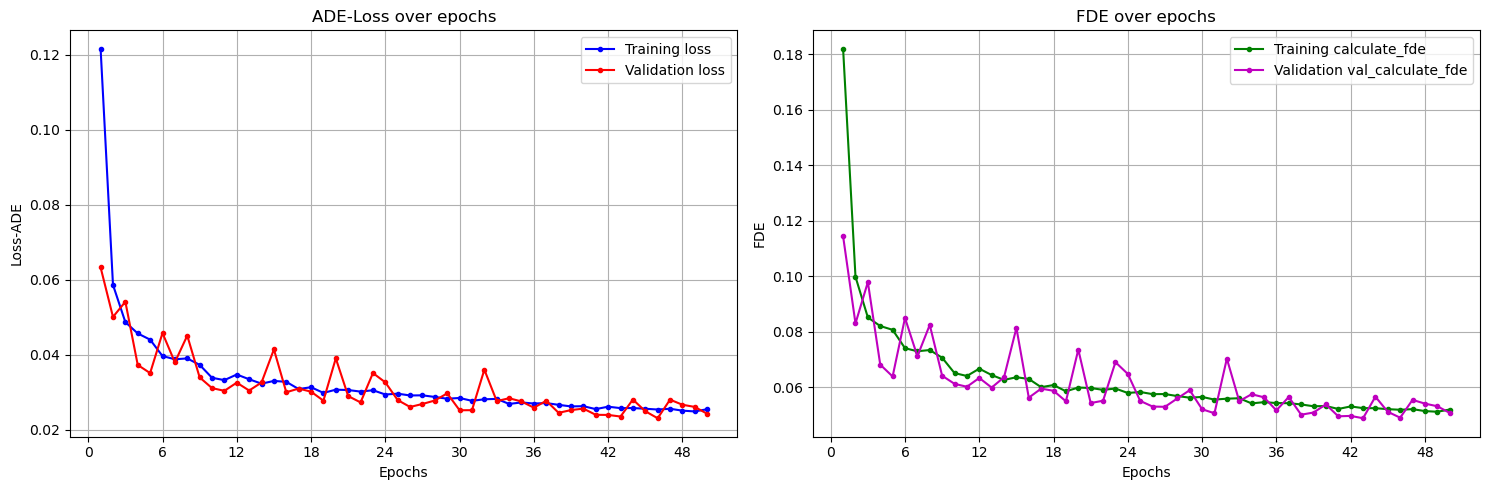

Finished training seq2seq_vanilla_eth

Sampling and plotting trajectories for seq2seq_vanilla_eth


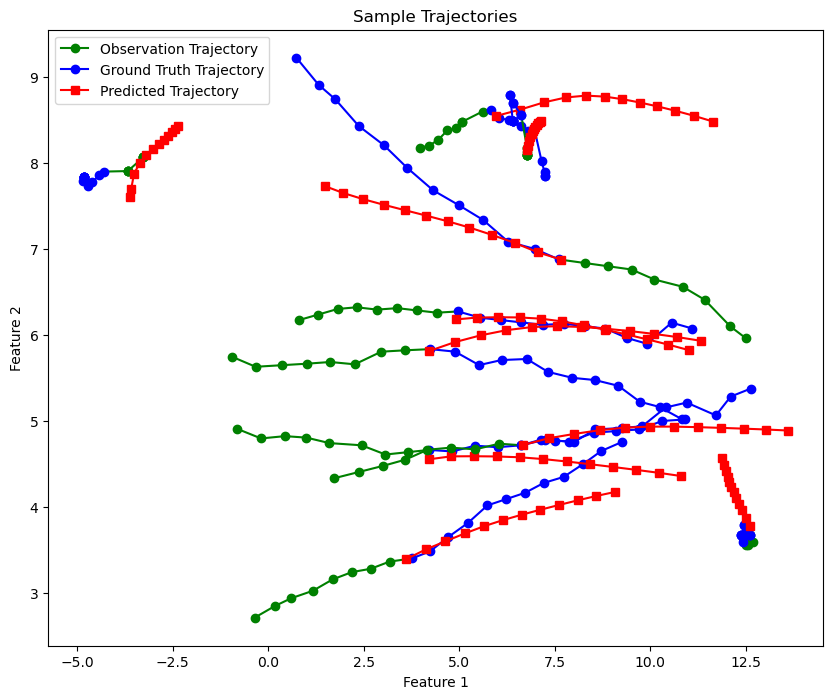


Training model for data_orig/zara1_orig
Epoch 1/50
244/245 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - calculate_ade: 0.1909 - calculate_fde: 0.2547 - loss: 0.1909
Epoch 1: val_loss improved from inf to 0.09436, saving model to seq2seq_vanilla_zara1.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - calculate_ade: 0.1903 - calculate_fde: 0.2540 - loss: 0.1903 - val_calculate_ade: 0.0947 - val_calculate_fde: 0.1634 - val_loss: 0.0944
Epoch 2/50
244/245 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - calculate_ade: 0.0607 - calculate_fde: 0.1014 - loss: 0.0607
Epoch 2: val_loss improved from 0.09436 to 0.05150, saving model to seq2seq_vanilla_zara1.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - calculate_ade: 0.0607 - calculate_fde: 0.1014 - loss: 0.0607 - val_calculate_ade: 0.0515 - val_calculate_fde: 0.0883 - val_loss: 0.0515
Epoch 3/50
244/245 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - calculate_ade: 0.0487 - calculate_fde: 0.0831 - loss: 0.0487
Epoch 3: val_loss improved from 0.05150 to 0.04375, saving mo

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)   │ (None, 8, 2)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_17 (InputLayer)   │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_16 (LSTM)                │ [(None, 256), (None,      │         265,216 │ input_layer_16[0][0]       │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_17 (LSTM)                │ [(None, None, 256),       │         265,216 │ input_layer_17[0][0],      │
│                               │ (None, 256), (None, 256)] │                 │ lstm_16[0][1],             │
│                               │                           │                 │ lstm_16[0][2]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_8            │ (None, None, 2)           │             514 │ lstm_17[0][0]              │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,592,840 (6.08 MB)

 Trainable params: 530,946 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,061,894 (4.05 MB)

Available keys in history: dict_keys(['calculate_ade', 'calculate_fde', 'loss', 'val_calculate_ade', 'val_calculate_fde', 'val_loss'])


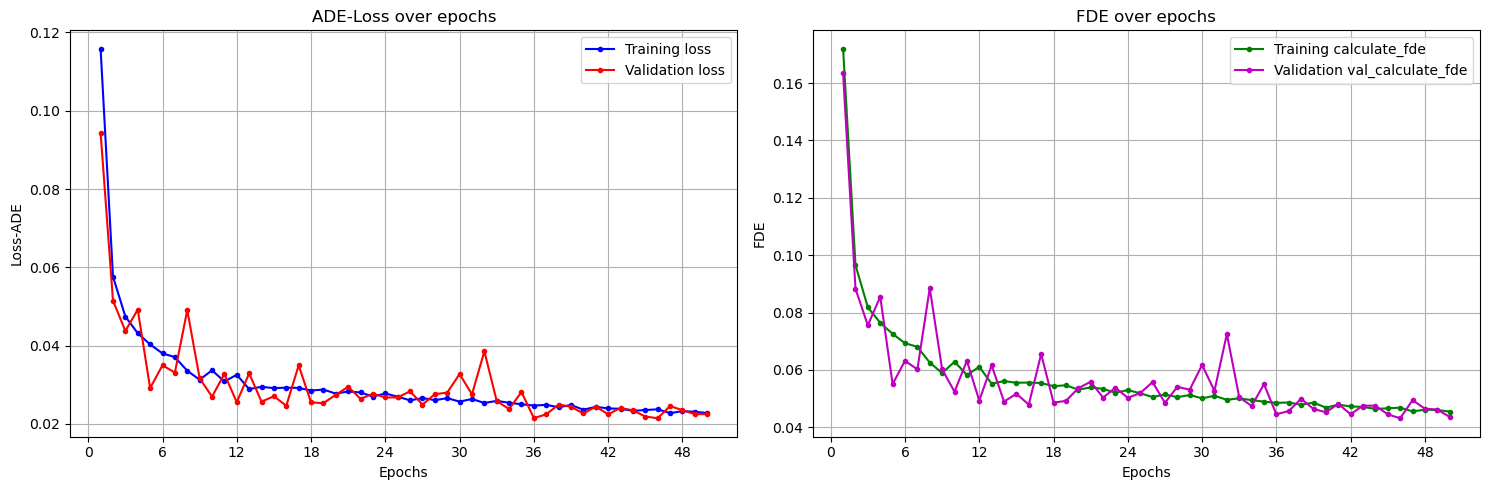

Finished training seq2seq_vanilla_zara1

Sampling and plotting trajectories for seq2seq_vanilla_zara1


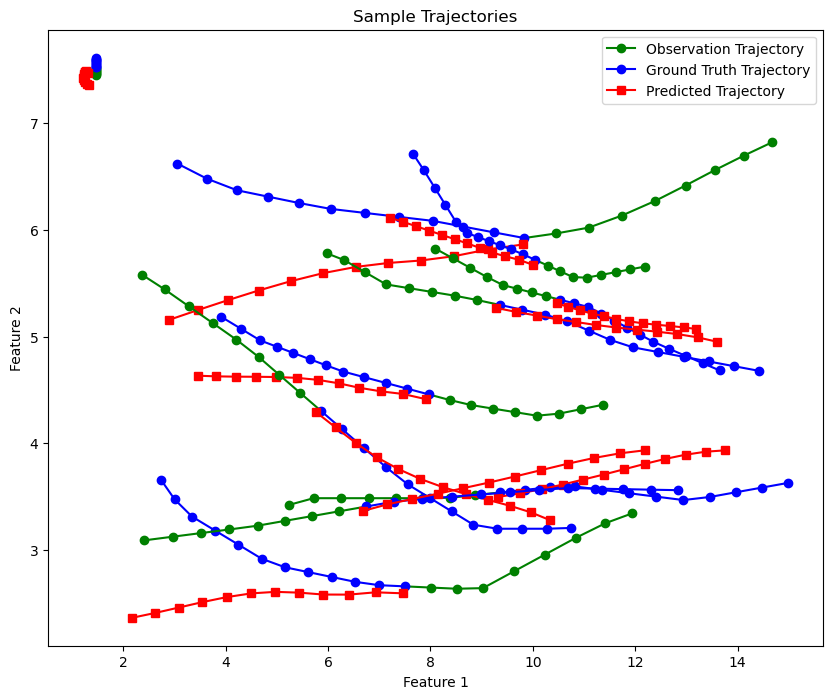


Training model for data_orig/zara2_orig
Epoch 1/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - calculate_ade: 0.1881 - calculate_fde: 0.2492 - loss: 0.1881
Epoch 1: val_loss improved from inf to 0.04933, saving model to seq2seq_vanilla_zara2.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - calculate_ade: 0.1875 - calculate_fde: 0.2486 - loss: 0.1875 - val_calculate_ade: 0.0493 - val_calculate_fde: 0.0825 - val_loss: 0.0493
Epoch 2/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - calculate_ade: 0.0678 - calculate_fde: 0.1145 - loss: 0.0678
Epoch 2: val_loss improved from 0.04933 to 0.04066, saving model to seq2seq_vanilla_zara2.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - calculate_ade: 0.0677 - calculate_fde: 0.1144 - loss: 0.0677 - val_calculate_ade: 0.0402 - val_calculate_fde: 0.0692 - val_loss: 0.0407
Epoch 3/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - calculate_ade: 0.0477 - calculate_fde: 0.0829 - loss: 0.0477
Epoch 3: val_loss did not improve from 0.04066
225/225 ━━━━━━

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)   │ (None, 8, 2)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_19 (InputLayer)   │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_18 (LSTM)                │ [(None, 256), (None,      │         265,216 │ input_layer_18[0][0]       │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_19 (LSTM)                │ [(None, None, 256),       │         265,216 │ input_layer_19[0][0],      │
│                               │ (None, 256), (None, 256)] │                 │ lstm_18[0][1],             │
│                               │                           │                 │ lstm_18[0][2]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_9            │ (None, None, 2)           │             514 │ lstm_19[0][0]              │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,592,840 (6.08 MB)

 Trainable params: 530,946 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,061,894 (4.05 MB)

Available keys in history: dict_keys(['calculate_ade', 'calculate_fde', 'loss', 'val_calculate_ade', 'val_calculate_fde', 'val_loss'])


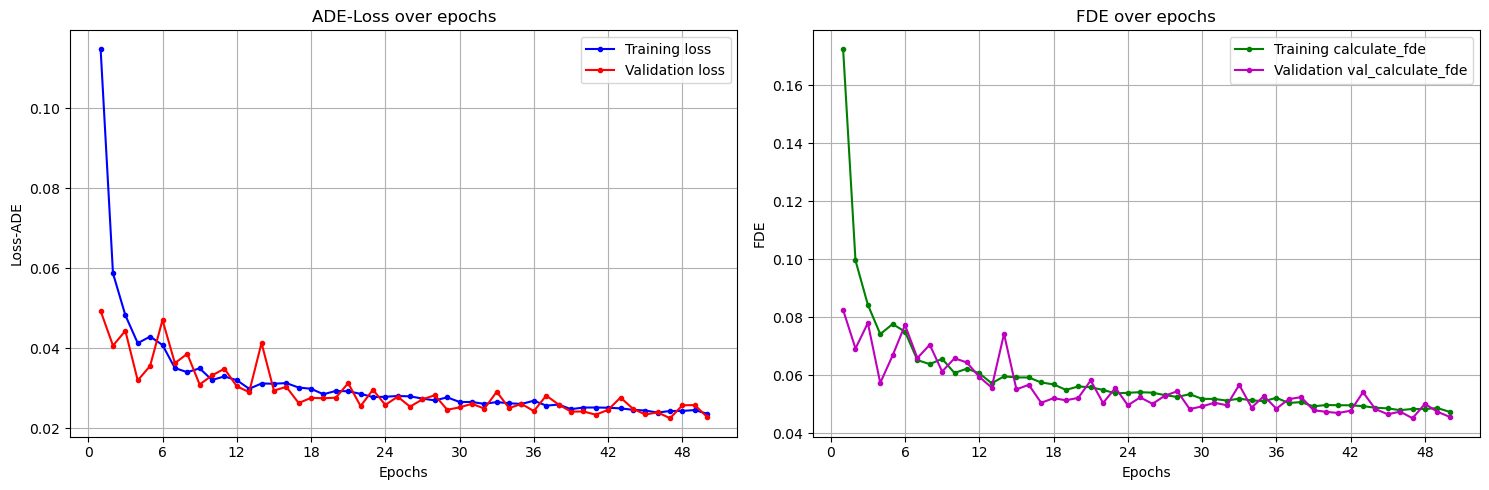

Finished training seq2seq_vanilla_zara2

Sampling and plotting trajectories for seq2seq_vanilla_zara2


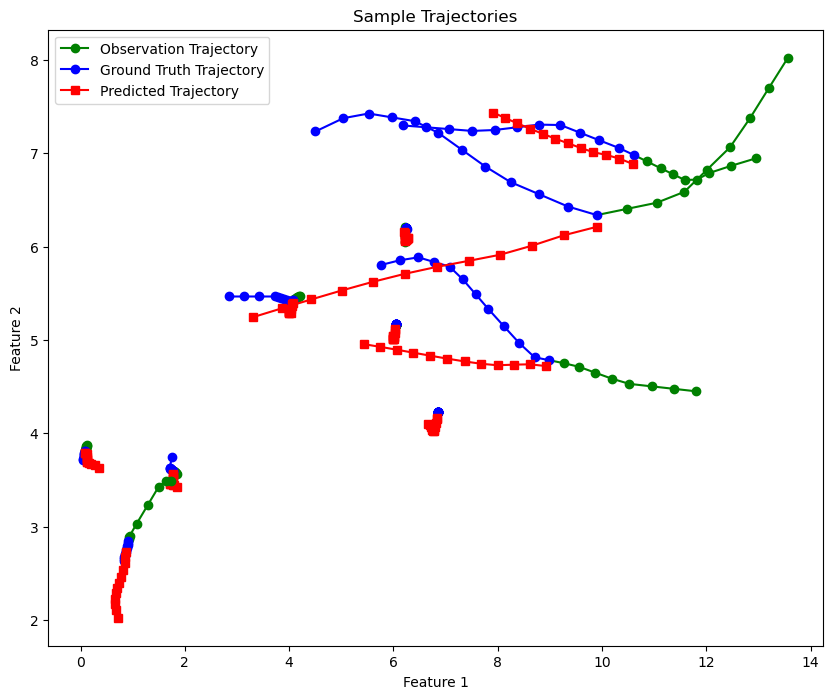


Training model for data_orig/hotel_orig
Epoch 1/50
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - calculate_ade: 0.1855 - calculate_fde: 0.2477 - loss: 0.1855
Epoch 1: val_loss improved from inf to 0.04720, saving model to seq2seq_vanilla_hotel.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - calculate_ade: 0.1849 - calculate_fde: 0.2471 - loss: 0.1849 - val_calculate_ade: 0.0471 - val_calculate_fde: 0.0786 - val_loss: 0.0472
Epoch 2/50
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - calculate_ade: 0.0575 - calculate_fde: 0.0986 - loss: 0.0575
Epoch 2: val_loss did not improve from 0.04720
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - calculate_ade: 0.0574 - calculate_fde: 0.0986 - loss: 0.0574 - val_calculate_ade: 0.0540 - val_calculate_fde: 0.0952 - val_loss: 0.0541
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - calculate_ade: 0.0511 - calculate_fde: 0.0911 - loss: 0.0511
Epoch 3: val_loss improved from 0.04720 to 0.03340, saving model to seq2seq_vanilla_hotel.keras
251/251 ━━━━━━

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)   │ (None, 8, 2)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_21 (InputLayer)   │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_20 (LSTM)                │ [(None, 256), (None,      │         265,216 │ input_layer_20[0][0]       │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_21 (LSTM)                │ [(None, None, 256),       │         265,216 │ input_layer_21[0][0],      │
│                               │ (None, 256), (None, 256)] │                 │ lstm_20[0][1],             │
│                               │                           │                 │ lstm_20[0][2]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_10           │ (None, None, 2)           │             514 │ lstm_21[0][0]              │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,592,840 (6.08 MB)

 Trainable params: 530,946 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,061,894 (4.05 MB)

Available keys in history: dict_keys(['calculate_ade', 'calculate_fde', 'loss', 'val_calculate_ade', 'val_calculate_fde', 'val_loss'])


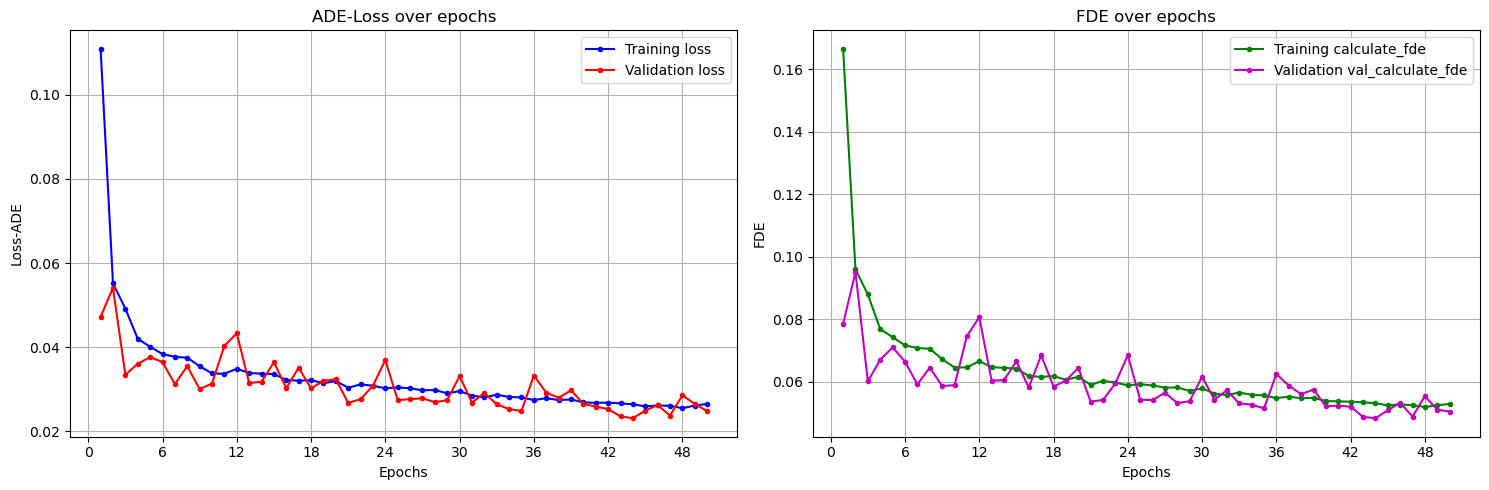

Finished training seq2seq_vanilla_hotel

Sampling and plotting trajectories for seq2seq_vanilla_hotel


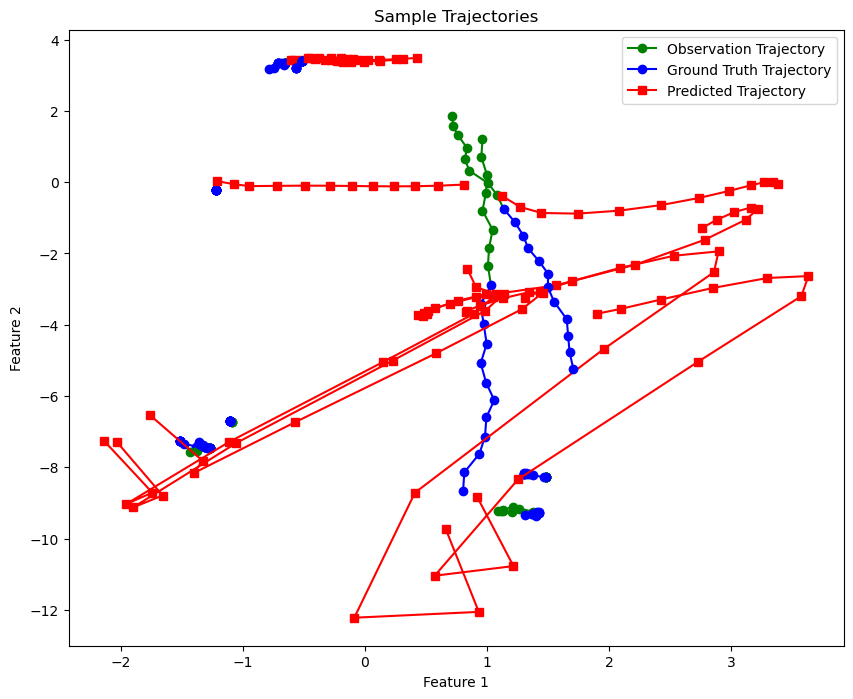


Training model for data_orig/univ_orig
Epoch 1/50
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - calculate_ade: 0.2622 - calculate_fde: 0.3340 - loss: 0.2622
Epoch 1: val_loss improved from inf to 0.09970, saving model to seq2seq_vanilla_univ.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - calculate_ade: 0.2603 - calculate_fde: 0.3320 - loss: 0.2603 - val_calculate_ade: 0.1004 - val_calculate_fde: 0.1560 - val_loss: 0.0997
Epoch 2/50
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - calculate_ade: 0.1076 - calculate_fde: 0.1738 - loss: 0.1076
Epoch 2: val_loss improved from 0.09970 to 0.03593, saving model to seq2seq_vanilla_univ.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - calculate_ade: 0.1073 - calculate_fde: 0.1734 - loss: 0.1073 - val_calculate_ade: 0.0363 - val_calculate_fde: 0.0568 - val_loss: 0.0359
Epoch 3/50
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - calculate_ade: 0.0555 - calculate_fde: 0.0929 - loss: 0.0555
Epoch 3: val_loss did not improve from 0.03593
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)   │ (None, 8, 2)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_23 (InputLayer)   │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_22 (LSTM)                │ [(None, 256), (None,      │         265,216 │ input_layer_22[0][0]       │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_23 (LSTM)                │ [(None, None, 256),       │         265,216 │ input_layer_23[0][0],      │
│                               │ (None, 256), (None, 256)] │                 │ lstm_22[0][1],             │
│                               │                           │                 │ lstm_22[0][2]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_11           │ (None, None, 2)           │             514 │ lstm_23[0][0]              │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,592,840 (6.08 MB)

 Trainable params: 530,946 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,061,894 (4.05 MB)

Available keys in history: dict_keys(['calculate_ade', 'calculate_fde', 'loss', 'val_calculate_ade', 'val_calculate_fde', 'val_loss'])


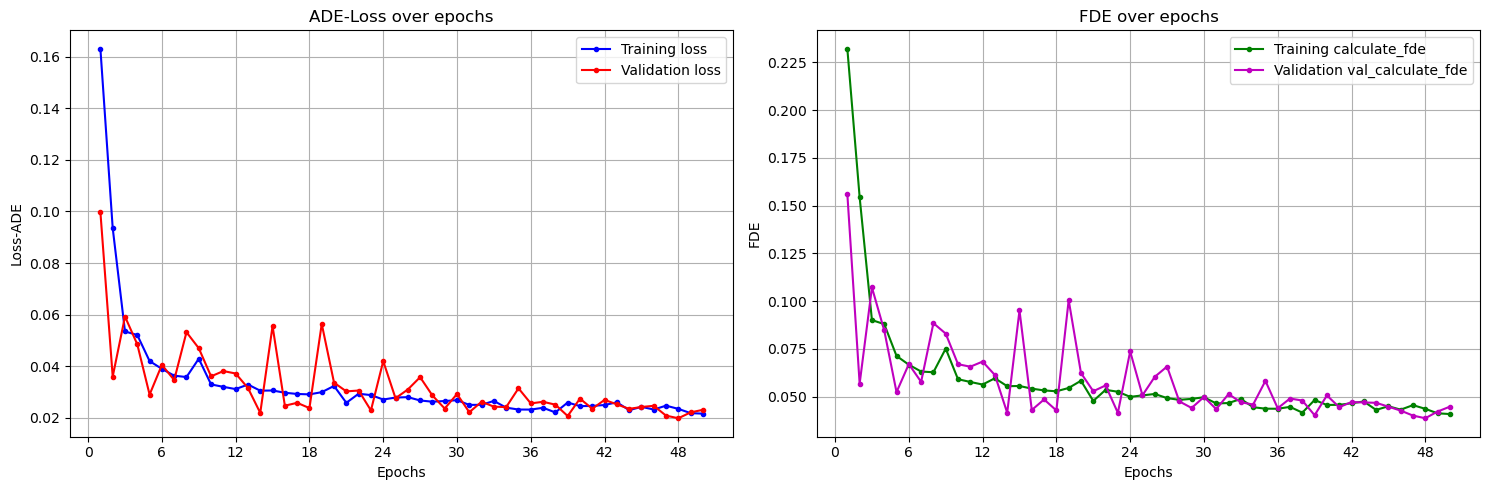

Finished training seq2seq_vanilla_univ

Sampling and plotting trajectories for seq2seq_vanilla_univ


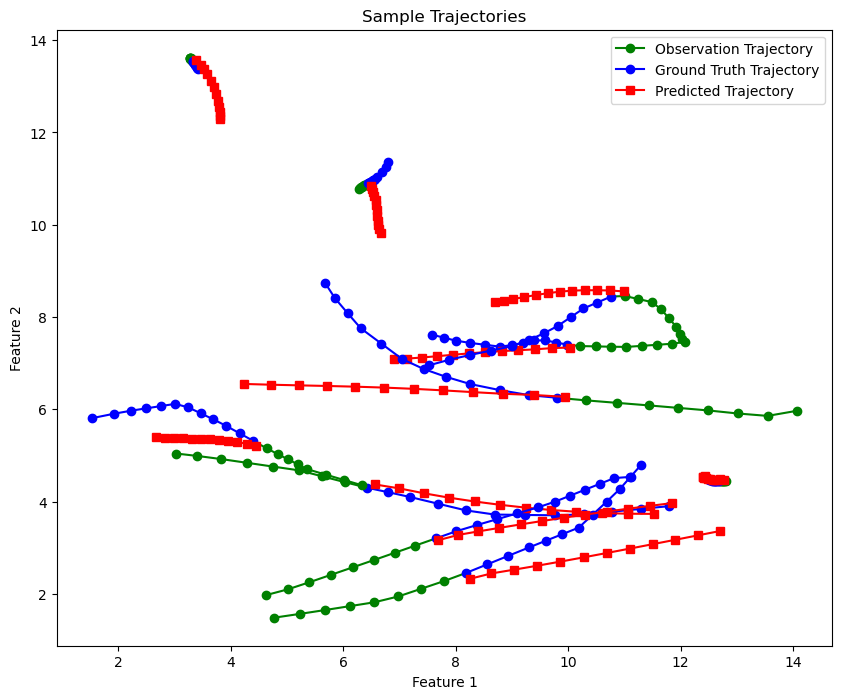

In [12]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

def normalize_data(data, scaler=None):
    if scaler is None:
        scaler = {'min': np.min(data, axis=(0, 1)), 'max': np.max(data, axis=(0, 1))}
    normalized_data = (data - scaler['min']) / (scaler['max'] - scaler['min'])
    return normalized_data, scaler

def inverse_normalize(data, scaler):
    return data * (scaler['max'] - scaler['min']) + scaler['min']

def train_seq2seq_model(data_folder, model_name, observation_number, output_seq_len, epochs=50):
    # Load data
    dataset_name = model_name.split("_")[-1]
    train_data = np.load(f'{data_folder}/{dataset_name}_orig_train_20.npy')
    val_data = np.load(f'{data_folder}/{dataset_name}_orig_val_20.npy')
    test_data = np.load(f'{data_folder}/{dataset_name}_orig_test_20.npy')

    # Normalize data
    train_data_norm, scaler = normalize_data(train_data)
    val_data_norm, _ = normalize_data(val_data, scaler)
    test_data_norm, _ = normalize_data(test_data, scaler)

    X_train, y_train = split_dataset(train_data_norm, observation_number)
    X_valid, y_valid = split_dataset(val_data_norm, observation_number)
    X_test, y_test = split_dataset(test_data_norm, observation_number)

    # Define parameters
    latent_dim = 256

    # Build Seq2seq model
    encoder_inputs = keras.layers.Input(shape=(observation_number, 2))
    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    decoder_inputs = keras.layers.Input(shape=(None, 2))
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = keras.layers.TimeDistributed(keras.layers.Dense(2))
    decoder_outputs = decoder_dense(decoder_outputs)
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss=calculate_ADE, metrics=[calculate_ADE, calculate_FDE])

    # Prepare training and validation dataset
    decoder_input_train = np.zeros((len(X_train), output_seq_len, 2))
    decoder_input_valid = np.zeros((len(X_valid), output_seq_len, 2))

    # Define checkpoint callback
    checkpoint = ModelCheckpoint(f"{model_name}.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

    # Train the model
    history = model.fit([X_train, decoder_input_train], y_train,
                        validation_data=([X_valid, decoder_input_valid], y_valid),
                        epochs=epochs, batch_size=128, callbacks=[checkpoint])

    # Evaluate the model
    decoder_input_test = np.zeros((len(X_test), output_seq_len, 2))
    results = model.evaluate([X_test, decoder_input_test], y_test)
    print(f"Model: {model_name}")
    print("Test ADE (normalized): ", results[1])
    print("Test FDE (normalized): ", results[2])

    # Predict trajectories
    predicted_y_test = model.predict([X_test, decoder_input_test])

    # Denormalize data
    X_test_orig = inverse_normalize(X_test, scaler)
    y_test_orig = inverse_normalize(y_test, scaler)
    predicted_y_test_orig = inverse_normalize(predicted_y_test, scaler)

    # Calculate metrics on original scale
    ade_orig = calculate_ADE(y_test_orig, predicted_y_test_orig)
    fde_orig = calculate_FDE(y_test_orig, predicted_y_test_orig)

    # 确保 ADE 和 FDE 是标量值
    if tf.is_tensor(ade_orig):
        ade_orig = ade_orig.numpy()
    if tf.is_tensor(fde_orig):
        fde_orig = fde_orig.numpy()

    print(f"Test ADE (original scale): {ade_orig:.4f}")
    print(f"Test FDE (original scale): {fde_orig:.4f}")

    return model, history, X_test_orig, y_test_orig, predicted_y_test_orig, scaler

# List of datasets and their corresponding model names
datasets = [
    ("data_orig/eth_orig", "seq2seq_vanilla_eth"),
    ("data_orig/zara1_orig", "seq2seq_vanilla_zara1"),
    ("data_orig/zara2_orig", "seq2seq_vanilla_zara2"),
    ("data_orig/hotel_orig", "seq2seq_vanilla_hotel"),
    ("data_orig/univ_orig", "seq2seq_vanilla_univ")
]

# Train models for each dataset
for data_folder, model_name in datasets:
    print(f"\nTraining model for {data_folder}")
    model, history, X_test, y_test, predicted_y_test, scaler = train_seq2seq_model(data_folder, model_name, observation_number, output_seq_len)
    
    # Print model summary
    model.summary()
    
    # Print history keys
    print("Available keys in history:", history.history.keys())
    
    # Plot learning curves
    plot_learning_curves(history)
    plt.savefig(f"{model_name}_learning_curves.png")
    plt.close()
    
    print(f"Finished training {model_name}\n")

    # Additional sampling and plotting for each model
    print(f"Sampling and plotting trajectories for {model_name}")
    d1, d2, d3 = sample_trajectories(X_test, y_test, predicted_y_test)
    plot_trajectories(d1, d2, d3)
    plt.savefig(f"{model_name}_trajectories.png")
    plt.close()

    # Save scaler for future use
    np.save(f"{model_name}_scaler.npy", scaler)


seq2seq_vanilla 
eth       Test ADE (original scale): 0.7164     Test FDE (original scale): 1.4344
zara1     Test ADE (original scale): 0.4662     Test FDE (original scale): 0.9292
zara2     Test ADE (original scale): 0.3983     Test FDE (original scale): 0.7896
hotel     Test ADE (original scale): 2.5386     Test FDE (original scale): 3.7218
univ      Test ADE (original scale): 0.8194     Test FDE (original scale): 1.5870

| Dataset | Test ADE | Test FDE |
|---|---|---|
| eth | 0.7164 | 1.4344 |
| zara1 | 0.4662 | 0.9292 |
| zara2 | 0.3983 | 0.7896 |
| hotel | 2.5386 | 3.7218 |
| univ | 0.8194 | 1.5870 |

# All 5 scenes - seq2seq


Training model for data_norm/eth_norm
Epoch 1/50
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - calculate_ade: 0.1995 - calculate_fde: 0.2876 - loss: 0.1995
Epoch 1: val_loss improved from inf to 0.08078, saving model to seq2seq_vanilla_eth.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - calculate_ade: 0.1989 - calculate_fde: 0.2868 - loss: 0.1989 - val_calculate_ade: 0.0808 - val_calculate_fde: 0.1457 - val_loss: 0.0808
Epoch 2/50
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - calculate_ade: 0.0667 - calculate_fde: 0.1236 - loss: 0.0667
Epoch 2: val_loss improved from 0.08078 to 0.05798, saving model to seq2seq_vanilla_eth.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - calculate_ade: 0.0666 - calculate_fde: 0.1235 - loss: 0.0666 - val_calculate_ade: 0.0579 - val_calculate_fde: 0.1097 - val_loss: 0.0580
Epoch 3/50
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - calculate_ade: 0.0595 - calculate_fde: 0.1138 - loss: 0.0595
Epoch 3: val_loss improved from 0.05798 to 0.05577, saving model to

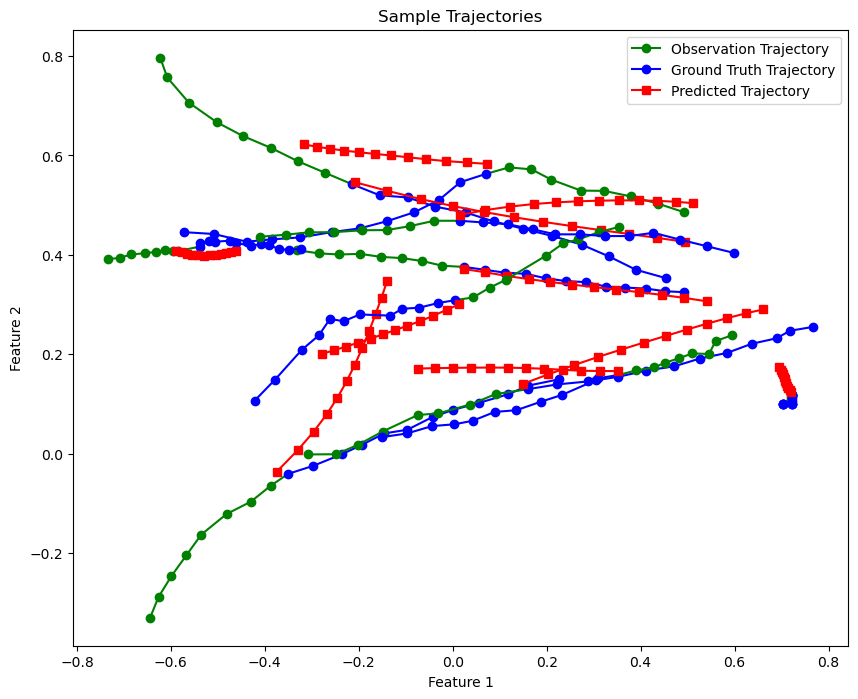

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 8, 2)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 256), (None,      │         265,216 │ input_layer[0][0]          │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, None, 256),       │         265,216 │ input_layer_1[0][0],       │
│                               │ (None, 256), (None, 256)] │                 │ lstm[0][1], lstm[0][2]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed              │ (None, None, 2)           │             514 │ lstm_1[0][0]               │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,592,840 (6.08 MB)

 Trainable params: 530,946 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,061,894 (4.05 MB)

Available keys in history: dict_keys(['calculate_ade', 'calculate_fde', 'loss', 'val_calculate_ade', 'val_calculate_fde', 'val_loss'])


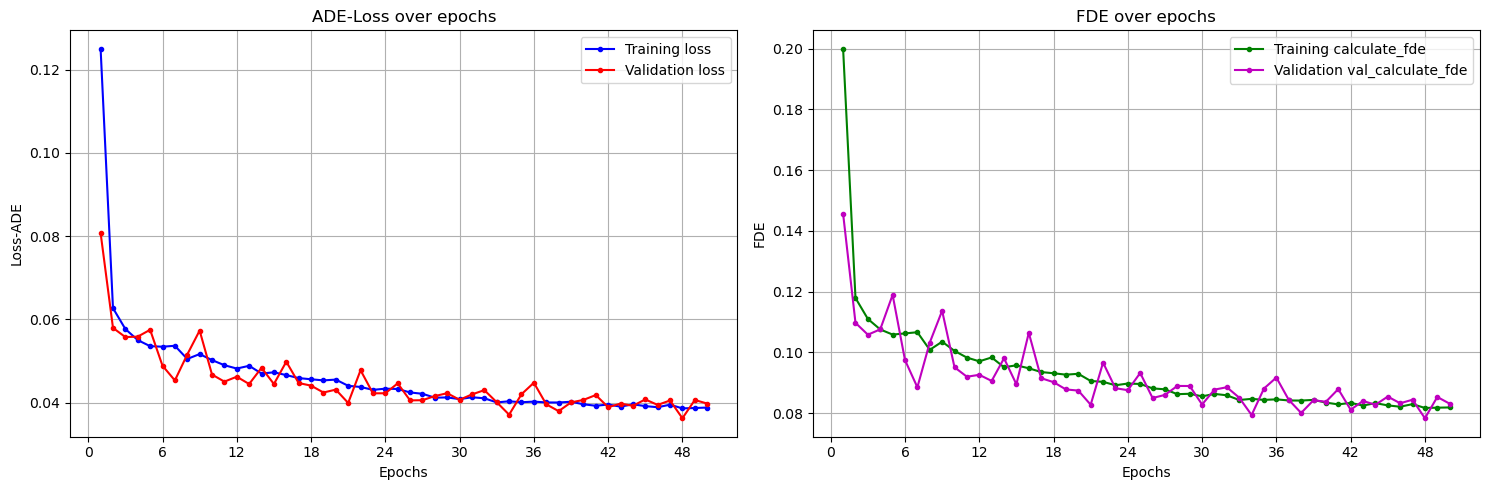

Finished training seq2seq_vanilla_eth

Sampling and plotting trajectories for seq2seq_vanilla_eth


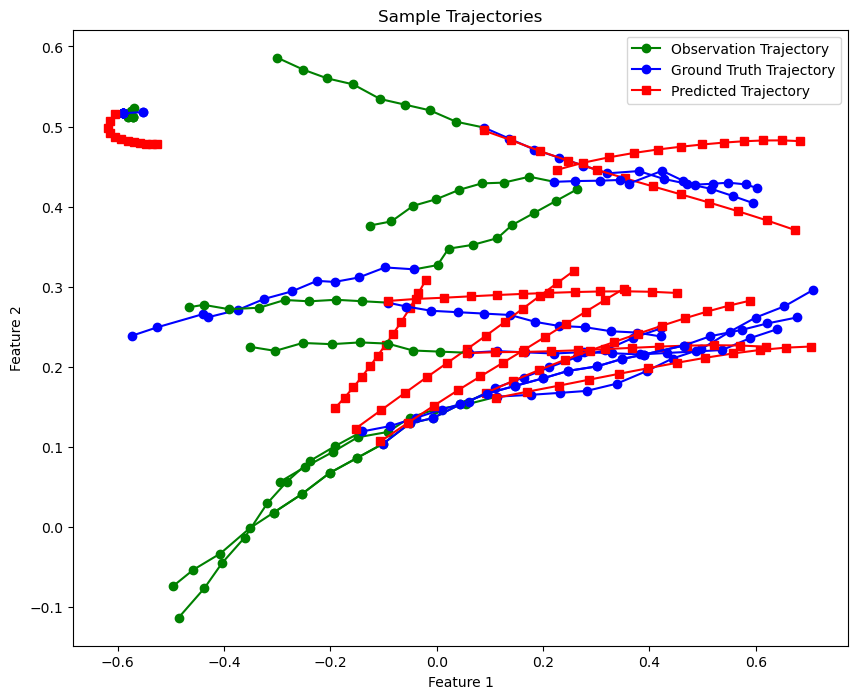


Training model for data_norm/zara1_norm
Epoch 1/50
244/245 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - calculate_ade: 0.1885 - calculate_fde: 0.2735 - loss: 0.1885
Epoch 1: val_loss improved from inf to 0.05676, saving model to seq2seq_vanilla_zara1.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - calculate_ade: 0.1879 - calculate_fde: 0.2728 - loss: 0.1879 - val_calculate_ade: 0.0565 - val_calculate_fde: 0.1015 - val_loss: 0.0568
Epoch 2/50
244/245 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - calculate_ade: 0.0609 - calculate_fde: 0.1142 - loss: 0.0609
Epoch 2: val_loss did not improve from 0.05676
245/245 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - calculate_ade: 0.0609 - calculate_fde: 0.1142 - loss: 0.0609 - val_calculate_ade: 0.0648 - val_calculate_fde: 0.1249 - val_loss: 0.0647
Epoch 3/50
244/245 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - calculate_ade: 0.0581 - calculate_fde: 0.1117 - loss: 0.0581
Epoch 3: val_loss did not improve from 0.05676
245/245 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - calculate_ade: 0.0

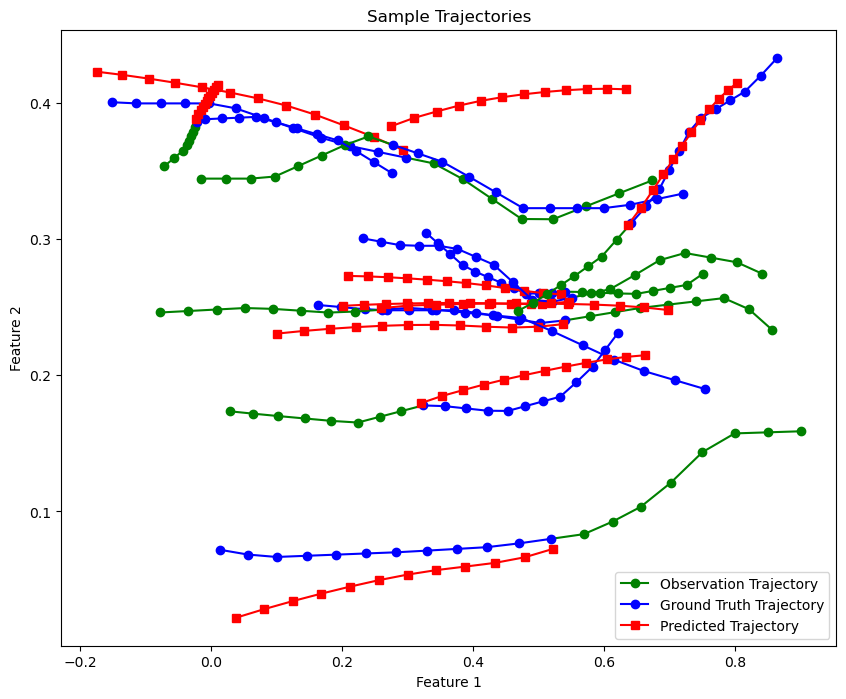

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 8, 2)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ [(None, 256), (None,      │         265,216 │ input_layer_2[0][0]        │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ [(None, None, 256),       │         265,216 │ input_layer_3[0][0],       │
│                               │ (None, 256), (None, 256)] │                 │ lstm_2[0][1], lstm_2[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_1            │ (None, None, 2)           │             514 │ lstm_3[0][0]               │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,592,840 (6.08 MB)

 Trainable params: 530,946 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,061,894 (4.05 MB)

Available keys in history: dict_keys(['calculate_ade', 'calculate_fde', 'loss', 'val_calculate_ade', 'val_calculate_fde', 'val_loss'])


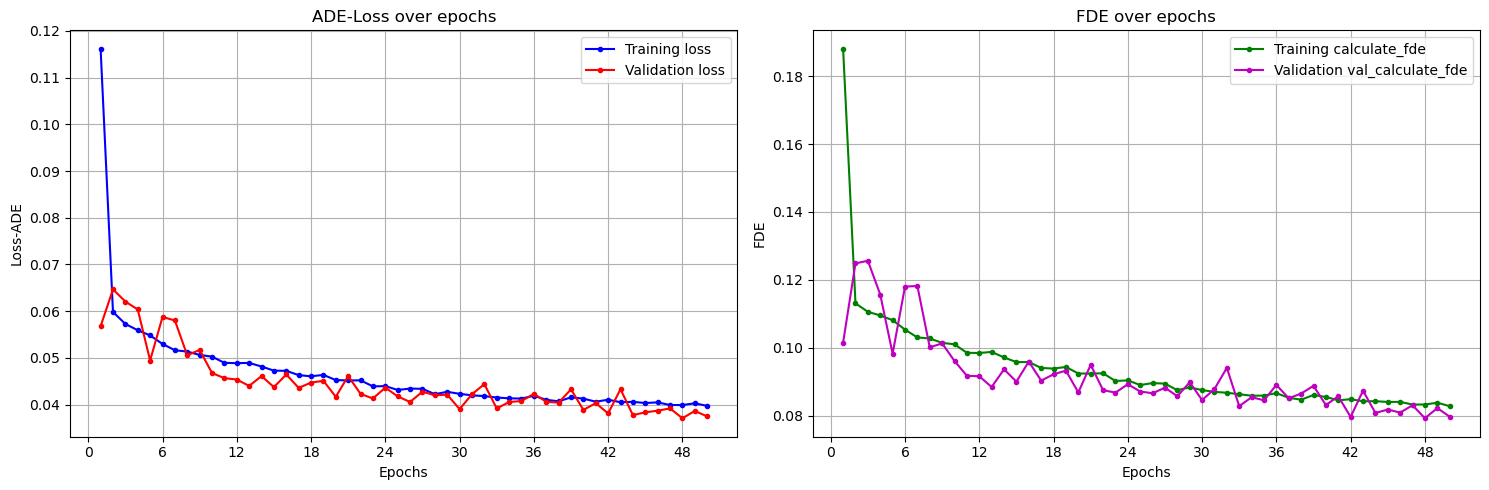

Finished training seq2seq_vanilla_zara1

Sampling and plotting trajectories for seq2seq_vanilla_zara1


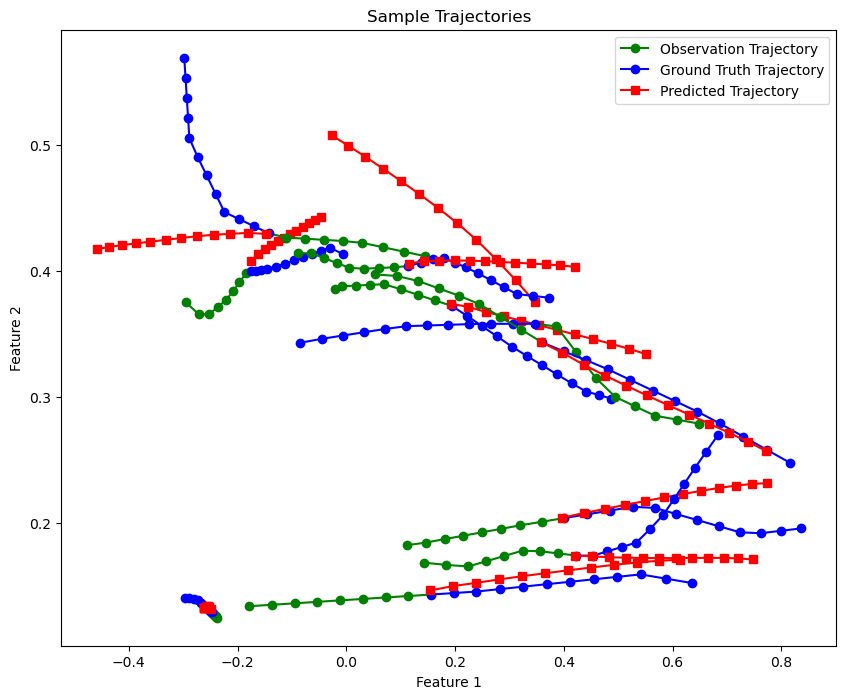


Training model for data_norm/zara2_norm
Epoch 1/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - calculate_ade: 0.1978 - calculate_fde: 0.2915 - loss: 0.1978
Epoch 1: val_loss improved from inf to 0.07887, saving model to seq2seq_vanilla_zara2.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - calculate_ade: 0.1972 - calculate_fde: 0.2907 - loss: 0.1972 - val_calculate_ade: 0.0784 - val_calculate_fde: 0.1552 - val_loss: 0.0789
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - calculate_ade: 0.0658 - calculate_fde: 0.1229 - loss: 0.0658
Epoch 2: val_loss improved from 0.07887 to 0.06850, saving model to seq2seq_vanilla_zara2.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - calculate_ade: 0.0658 - calculate_fde: 0.1229 - loss: 0.0658 - val_calculate_ade: 0.0681 - val_calculate_fde: 0.1316 - val_loss: 0.0685
Epoch 3/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - calculate_ade: 0.0606 - calculate_fde: 0.1164 - loss: 0.0606
Epoch 3: val_loss improved from 0.06850 to 0.05690, saving mo

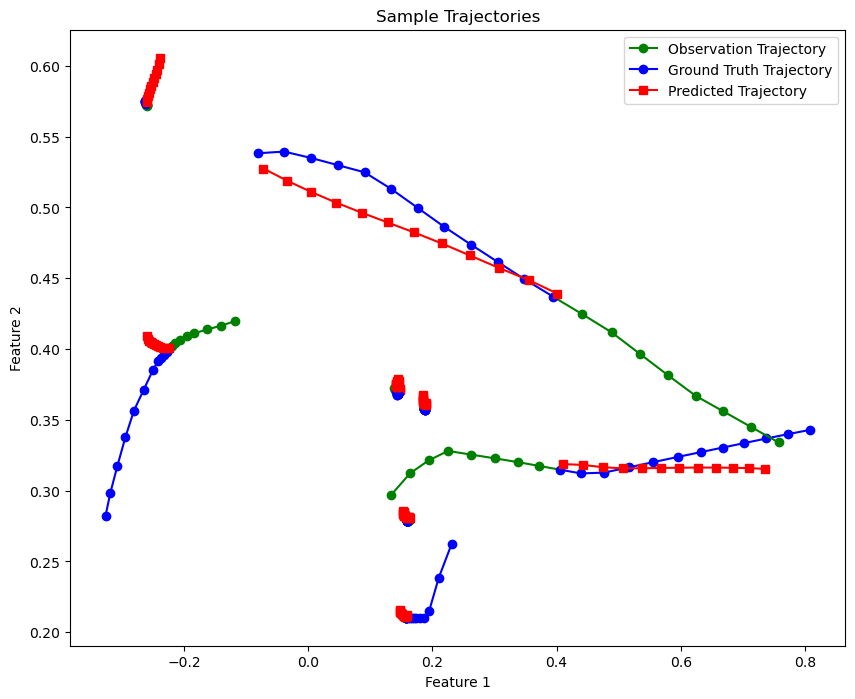

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 8, 2)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_4 (LSTM)                 │ [(None, 256), (None,      │         265,216 │ input_layer_4[0][0]        │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_5 (LSTM)                 │ [(None, None, 256),       │         265,216 │ input_layer_5[0][0],       │
│                               │ (None, 256), (None, 256)] │                 │ lstm_4[0][1], lstm_4[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_2            │ (None, None, 2)           │             514 │ lstm_5[0][0]               │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,592,840 (6.08 MB)

 Trainable params: 530,946 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,061,894 (4.05 MB)

Available keys in history: dict_keys(['calculate_ade', 'calculate_fde', 'loss', 'val_calculate_ade', 'val_calculate_fde', 'val_loss'])


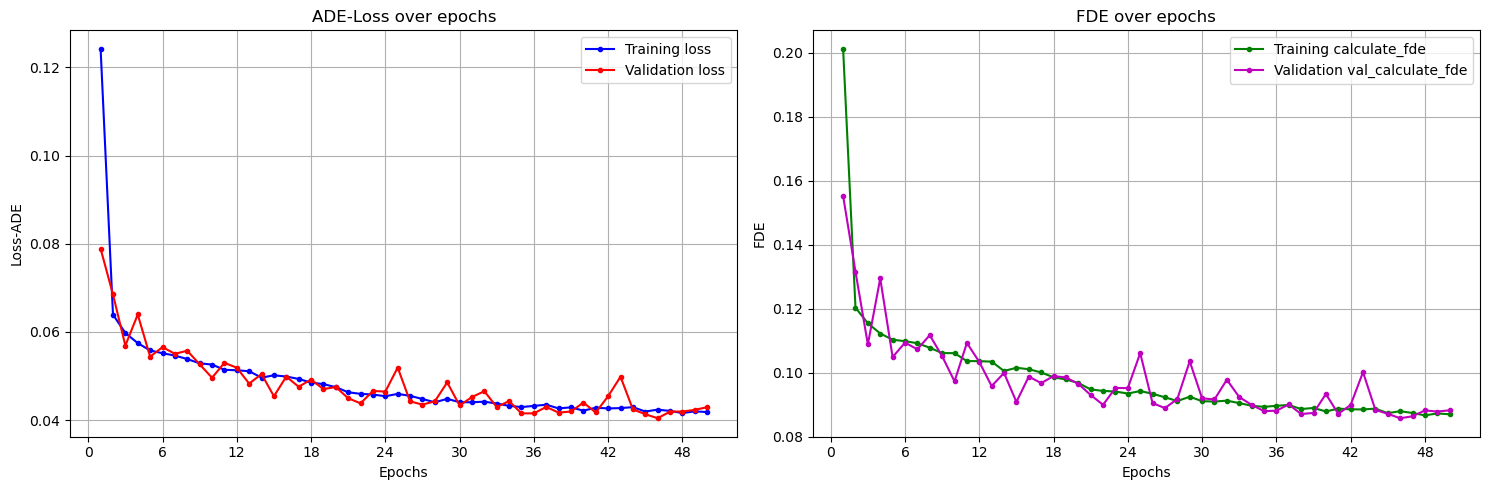

Finished training seq2seq_vanilla_zara2

Sampling and plotting trajectories for seq2seq_vanilla_zara2


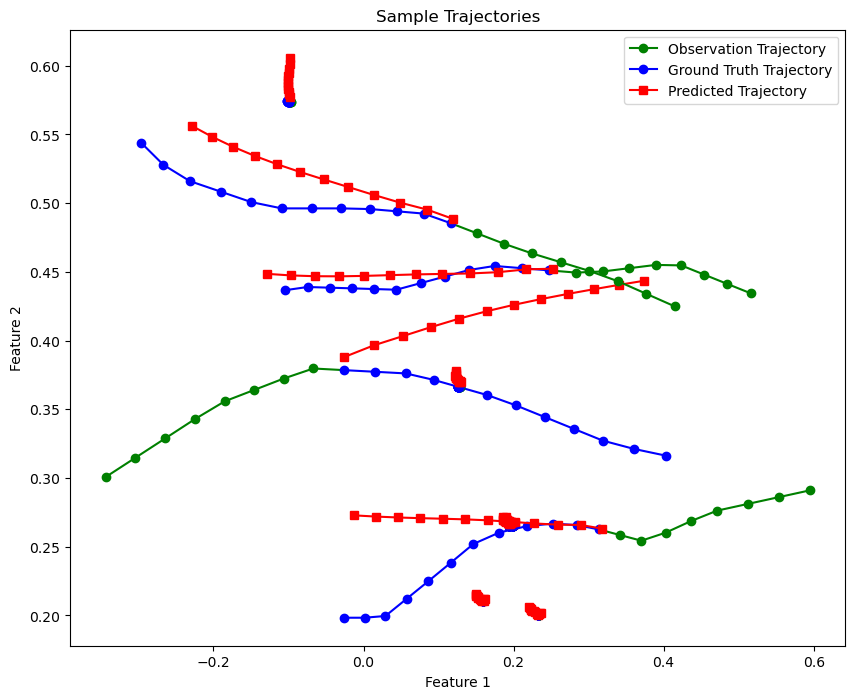


Training model for data_norm/hotel_norm
Epoch 1/50
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - calculate_ade: 0.1819 - calculate_fde: 0.2680 - loss: 0.1819
Epoch 1: val_loss improved from inf to 0.06231, saving model to seq2seq_vanilla_hotel.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - calculate_ade: 0.1813 - calculate_fde: 0.2673 - loss: 0.1813 - val_calculate_ade: 0.0624 - val_calculate_fde: 0.1180 - val_loss: 0.0623
Epoch 2/50
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - calculate_ade: 0.0618 - calculate_fde: 0.1157 - loss: 0.0618
Epoch 2: val_loss improved from 0.06231 to 0.05517, saving model to seq2seq_vanilla_hotel.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - calculate_ade: 0.0618 - calculate_fde: 0.1157 - loss: 0.0618 - val_calculate_ade: 0.0552 - val_calculate_fde: 0.1043 - val_loss: 0.0552
Epoch 3/50
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - calculate_ade: 0.0560 - calculate_fde: 0.1077 - loss: 0.0560
Epoch 3: val_loss improved from 0.05517 to 0.05037, saving mo

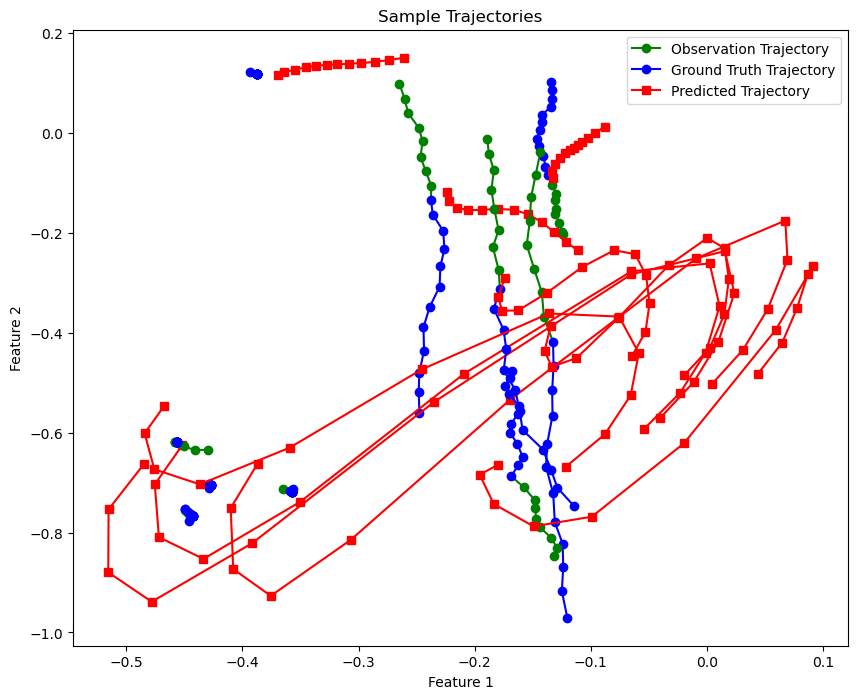

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 8, 2)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_7 (InputLayer)    │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_6 (LSTM)                 │ [(None, 256), (None,      │         265,216 │ input_layer_6[0][0]        │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_7 (LSTM)                 │ [(None, None, 256),       │         265,216 │ input_layer_7[0][0],       │
│                               │ (None, 256), (None, 256)] │                 │ lstm_6[0][1], lstm_6[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_3            │ (None, None, 2)           │             514 │ lstm_7[0][0]               │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,592,840 (6.08 MB)

 Trainable params: 530,946 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,061,894 (4.05 MB)

Available keys in history: dict_keys(['calculate_ade', 'calculate_fde', 'loss', 'val_calculate_ade', 'val_calculate_fde', 'val_loss'])


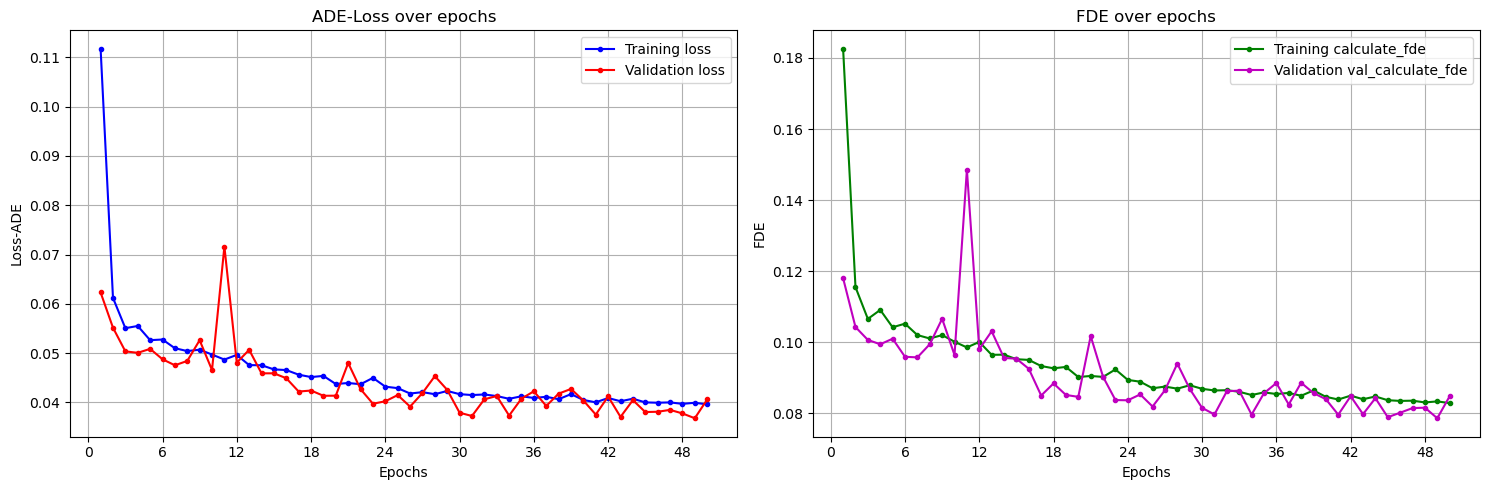

Finished training seq2seq_vanilla_hotel

Sampling and plotting trajectories for seq2seq_vanilla_hotel


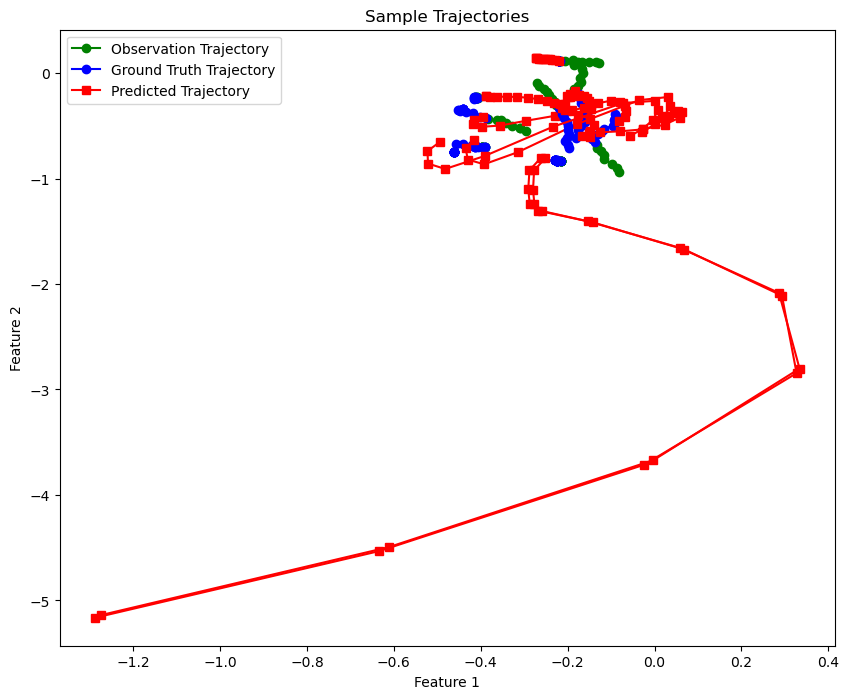


Training model for data_norm/univ_norm
Epoch 1/50
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - calculate_ade: 0.2434 - calculate_fde: 0.3507 - loss: 0.2434
Epoch 1: val_loss improved from inf to 0.07504, saving model to seq2seq_vanilla_univ.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - calculate_ade: 0.2417 - calculate_fde: 0.3487 - loss: 0.2417 - val_calculate_ade: 0.0759 - val_calculate_fde: 0.1327 - val_loss: 0.0750
Epoch 2/50
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - calculate_ade: 0.0664 - calculate_fde: 0.1175 - loss: 0.0664
Epoch 2: val_loss improved from 0.07504 to 0.04627, saving model to seq2seq_vanilla_univ.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - calculate_ade: 0.0663 - calculate_fde: 0.1173 - loss: 0.0663 - val_calculate_ade: 0.0465 - val_calculate_fde: 0.0877 - val_loss: 0.0463
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - calculate_ade: 0.0519 - calculate_fde: 0.0965 - loss: 0.0519
Epoch 3: val_loss improved from 0.04627 to 0.04431, saving model to seq2seq_

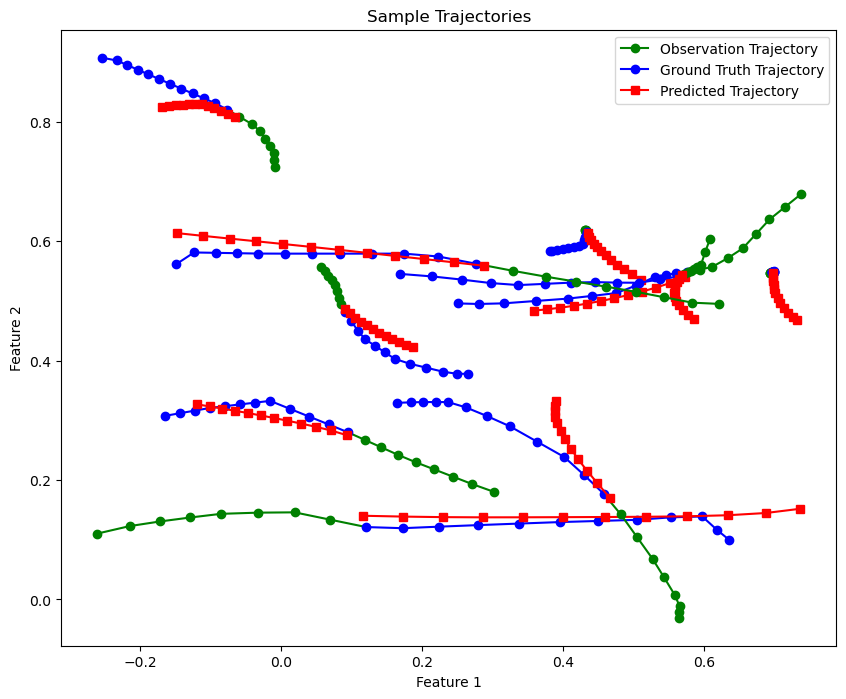

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 8, 2)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_9 (InputLayer)    │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_8 (LSTM)                 │ [(None, 256), (None,      │         265,216 │ input_layer_8[0][0]        │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_9 (LSTM)                 │ [(None, None, 256),       │         265,216 │ input_layer_9[0][0],       │
│                               │ (None, 256), (None, 256)] │                 │ lstm_8[0][1], lstm_8[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_4            │ (None, None, 2)           │             514 │ lstm_9[0][0]               │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,592,840 (6.08 MB)

 Trainable params: 530,946 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,061,894 (4.05 MB)

Available keys in history: dict_keys(['calculate_ade', 'calculate_fde', 'loss', 'val_calculate_ade', 'val_calculate_fde', 'val_loss'])


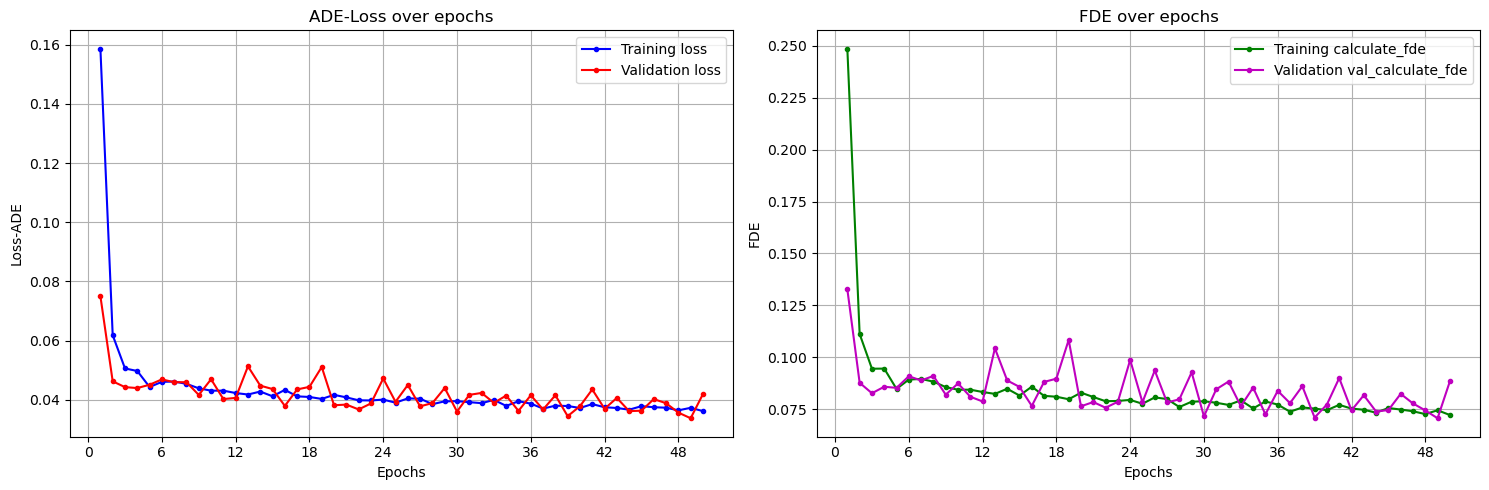

Finished training seq2seq_vanilla_univ

Sampling and plotting trajectories for seq2seq_vanilla_univ


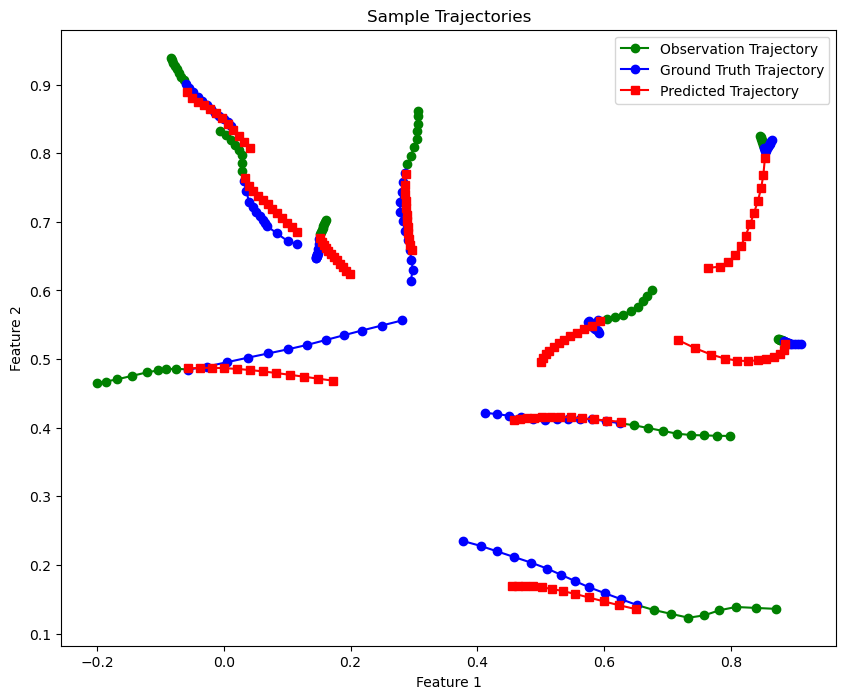

In [5]:

def train_seq2seq_model(data_folder, model_name, observation_number, output_seq_len, epochs=50):
    # Load data
    train_data = np.load(f'{data_folder}/{model_name.split("_")[-1]}_train_20.npy')
    val_data = np.load(f'{data_folder}/{model_name.split("_")[-1]}_val_20.npy')
    test_data = np.load(f'{data_folder}/{model_name.split("_")[-1]}_test_20.npy')

    X_train, y_train = split_dataset(train_data, observation_number)
    X_valid, y_valid = split_dataset(val_data, observation_number)
    X_test, y_test = split_dataset(test_data, observation_number)

    # Define parameters
    latent_dim = 256

    # Build Seq2seq model
    encoder_inputs = keras.layers.Input(shape=(observation_number, 2))
    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]

    decoder_inputs = keras.layers.Input(shape=(None, 2))
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = keras.layers.TimeDistributed(keras.layers.Dense(2))
    decoder_outputs = decoder_dense(decoder_outputs)

    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss=calculate_ADE, metrics=[calculate_ADE, calculate_FDE])


    # Prepare training and validation dataset
    decoder_input_train = np.zeros((len(X_train), output_seq_len, 2))
    decoder_input_valid = np.zeros((len(X_valid), output_seq_len, 2))

    # Define checkpoint callback
    checkpoint = ModelCheckpoint(f"{model_name}.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

    # Train the model
    history = model.fit([X_train, decoder_input_train], y_train,
                        validation_data=([X_valid, decoder_input_valid], y_valid),
                        epochs=epochs, batch_size=128, callbacks=[checkpoint])

    # Evaluate the model
    decoder_input_test = np.zeros((len(X_test), output_seq_len, 2))
    results = model.evaluate([X_test, decoder_input_test], y_test)

    print(f"Model: {model_name}")
    print("Test ADE: ", results[1])
    print("Test FDE: ", results[2])

    # Predict trajectories
    predicted_y_test = model.predict([X_test, decoder_input_test])

    # Sample and plot trajectories
    d1, d2, d3 = sample_trajectories(X_test, y_test, predicted_y_test)
    plot_trajectories(d1, d2, d3)

    return model, history, X_test, y_test, predicted_y_test

# List of datasets and their corresponding model names
datasets = [
    ("data_norm/eth_norm", "seq2seq_vanilla_eth"),
    ("data_norm/zara1_norm", "seq2seq_vanilla_zara1"),
    ("data_norm/zara2_norm", "seq2seq_vanilla_zara2"),
    ("data_norm/hotel_norm", "seq2seq_vanilla_hotel"),
    ("data_norm/univ_norm", "seq2seq_vanilla_univ")
]

# Train models for each dataset
for data_folder, model_name in datasets:
    print(f"\nTraining model for {data_folder}")
    model, history, X_test, y_test, predicted_y_test = train_seq2seq_model(data_folder, model_name, observation_number, output_seq_len)
    
    # Print model summary
    model.summary()
    
    # Print history keys
    print("Available keys in history:", history.history.keys())
    
    # Plot learning curves
    plot_learning_curves(history)
    
    print(f"Finished training {model_name}\n")

    # Additional sampling and plotting for each model
    print(f"Sampling and plotting trajectories for {model_name}")
    d1, d2, d3 = sample_trajectories(X_test, y_test, predicted_y_test)
    plot_trajectories(d1, d2, d3)
    plt.savefig(f"{model_name}_trajectories.png")
    plt.close()

| Dataset | Test ADE | Test FDE |
|---------|----------|----------|
| ETH     | 0.06     | 0.11     |
| zara1   | 0.03     | 0.07     |
| zara2   | 0.03     | 0.06     |
| hotel   | 0.47     | 0.98     |
| univ    | 0.06     | 0.13     |


# ETH

In [ ]:
# 加载训练集
train_data = np.load('data_norm/eth_norm/eth_train_20.npy')

# 加载验证集
val_data = np.load('data_norm/eth_norm/eth_val_20.npy')

# 加载测试集
test_data = np.load('data_norm/eth_norm/eth_test_20.npy')

X_train,  y_train =  split_dataset(train_data, observation_number)
X_valid ,   y_valid   =  split_dataset(val_data  , observation_number)
X_test,   y_test  =  split_dataset(test_data , observation_number)

In [ ]:
X_train.shape,  y_train.shape,X_val.shape,   y_val.shape,   X_test.shape,   y_test.shape 

In [ ]:
# define the payameter
latent_dim = 256

# build Seq2seq model
encoder_inputs = keras.layers.Input(shape=(observation_number, 2))  # input（observation_number, 2）
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = keras.layers.Input(shape=(None, 2))  # encoder input （None, 2）
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.TimeDistributed(keras.layers.Dense(2))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model_name = "Seq2Seq_vanilla_Model"
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# compile，uese calculate_ADE as loss function
model.compile(optimizer='adam', loss=calculate_ADE, metrics=[calculate_ADE, calculate_FDE])

# prepareing traing and validation dataset
decoder_input_train = np.zeros((len(X_train), output_seq_len, 2))
decoder_input_valid = np.zeros((len(X_valid), output_seq_len, 2))

# Define checkpoint callback to save the best model
checkpoint = ModelCheckpoint(f"{model_name}.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

# train the model
# Train the model
history = model.fit([X_train, decoder_input_train], y_train,
                    validation_data=([X_valid, decoder_input_valid], y_valid),
                    epochs=3, batch_size=128, callbacks=[checkpoint])


decoder_input_test = np.zeros((len(X_test), output_seq_len, 2))

# Print model summary
model.summary()

# evaluate the model
results = model.evaluate([X_test, decoder_input_test], y_test)
print("Test ADE: ", results[1])
print("Test FDE: ", results[2])


# print the history key
print("Available keys in history:", history.history.keys())

#
plot_learning_curves(history)

# Only_one_Conv1D

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, SimpleRNN, TimeDistributed, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the model
model_name = " Only_one_Conv1D"
model = Sequential([
    Input(shape=(observation_number, 2)),  # explicit input
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', dilation_rate=1),
    SimpleRNN(128, return_sequences=True),  # First RNN Layer
    SimpleRNN(128, return_sequences=True),  # Second RNN layer
    SimpleRNN(128, return_sequences=True),  # Third RNN Layer
    SimpleRNN(128, return_sequences=True),  # Fourth RNNLayer
    TimeDistributed(Dense(output_seq_len * 2)),  # TimeDistributed layer
    Reshape((observation_number, output_seq_len, 2))  # Reshape to (observation_number, output_seq_len, 2)
])

# Compile the model
model.compile(optimizer=Adam(), loss=calculate_ADE, metrics=[calculate_ADE, calculate_FDE])

# Define checkpoint callback to save the best model
checkpoint = ModelCheckpoint(f"{model_name}.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

# Train the model
history = model.fit(X_train, y_train, batch_size=128, epochs=2, validation_data=(X_valid, y_valid), callbacks=[checkpoint])

# Print model summary
model.summary()

# Save the final model
model.save(f"{model_name}.keras")

Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/compile_loss/calculate_ade/sub/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\qinlo\.conda\envs\cits5508-2024\Lib\asyncio\base_events.py", line 639, in run_forever

  File "C:\Users\qinlo\.conda\envs\cits5508-2024\Lib\asyncio\base_events.py", line 1985, in _run_once

  File "C:\Users\qinlo\.conda\envs\cits5508-2024\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 531, in process_one

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 359, in execute_request

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 775, in execute_request

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 446, in do_execute

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\qinlo\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\qinlo\AppData\Local\Temp\ipykernel_23876\777283341.py", line 25, in <module>

  File "C:\Users\qinlo\.conda\envs\cits5508-2024\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\qinlo\.conda\envs\cits5508-2024\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 318, in fit

  File "C:\Users\qinlo\.conda\envs\cits5508-2024\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\qinlo\.conda\envs\cits5508-2024\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\qinlo\.conda\envs\cits5508-2024\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 70, in train_step

Incompatible shapes: [128,12,2] vs. [128,8,12,2]
	 [[{{node gradient_tape/compile_loss/calculate_ade/sub/BroadcastGradientArgs}}]] [Op:__inference_one_step_on_iterator_7554]